In [ ]:
import re
import numpy as np
import pandas as pd

import nltk

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
FILE_PATH ='/content/drive/MyDrive/training.1600000.processed.noemoticon.csv'
COL_NAMES = ['target','ids','date','flag','user','text']
df = pd.read_csv(FILE_PATH, encoding = "ISO-8859-1", names = COL_NAMES)

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [ ]:
df["target"].unique()

array([0, 4])

In [ ]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [ ]:
df.shape

(1600000, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
df = df[['text','target']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [ ]:
df['target'].unique()

array([0, 4])

In [ ]:
df['target'] = df['target'].replace(to_replace = 4, value = 1)
df.tail()

,text,target
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1
1599999,happy #charitytuesday @theNSPCC @SparksCharity...,1


<Axes: xlabel='target', ylabel='count'>

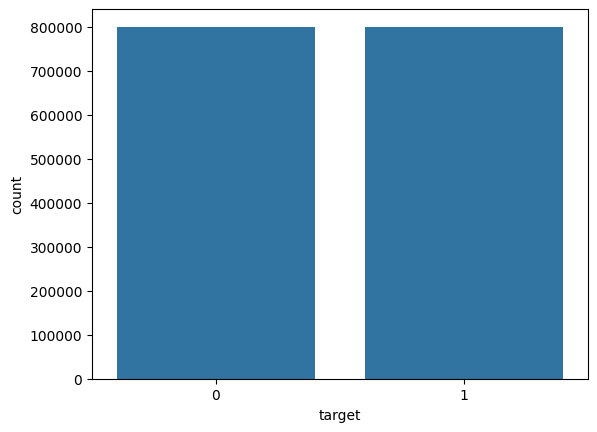

In [ ]:
sns.countplot(data= df, x = 'target')

In [ ]:
df_pos = df[df['target'] == 1].iloc[:200000]
df_neg = df[df['target'] == 0].iloc[:200000]
df_new = pd.concat([df_neg,df_pos], axis = 0)

In [ ]:
df_new['text'] = df_new['text'].str.lower()

In [ ]:
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

def removing_consecutive (data):
    return re.sub(sequencePattern, seqReplacePattern, data)

df_new['text'] = df_new['text'].apply(removing_consecutive)
df_new['text'].tail()

999995             @healingsinger thank you, i needed that 
999996    @vactress http://bit.ly/cadea  maybe this is m...
999997    @brat13 hell, windows 7 will be out of my pric...
999998    @jigardoshi neah.. i wish! just reminiscing  r...
999999    @msteagan ..and by the way: i rewatched sun go...
Name: text, dtype: object

In [ ]:
url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"

def cleaning_URLs(data):
    return re.sub(url_pattern,'',data)

df_new['text'] = df_new['text'].apply(cleaning_URLs)
df_new['text'].tail()

999995             @healingsinger thank you, i needed that 
999996                  @vactress   maybe this is more you 
999997    @brat13 hell, windows 7 will be out of my pric...
999998    @jigardoshi neah.. i wish! just reminiscing  r...
999999    @msteagan ..and by the way: i rewatched sun go...
Name: text, dtype: object

In [ ]:
# Replacing emojis
# Define Emojis dictionary API
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

def replacing_emojis(data):
    text = []
    for word in data.split():
        if word not in emojis.keys():
            text.append(word)
        else:
            text.append(emojis[word])
    return ' '.join(text)

df_new['text'] = df_new['text'].apply(replacing_emojis)
df_new['text'].tail()


999995              @healingsinger thank you, i needed that
999996                     @vactress maybe this is more you
999997    @brat13 hell, windows 7 will be out of my pric...
999998    @jigardoshi neah.. i wish! just reminiscing re...
999999    @msteagan ..and by the way: i rewatched sun go...
Name: text, dtype: object

In [ ]:
# Removing Tags
tag_pattern = '@[^\s]+'

def removing_tag (data):
    return re.sub(tag_pattern,'',data)

df_new['text'] = df_new['text'].apply(removing_tag)
df_new['text'].tail()

999995                             thank you, i needed that
999996                               maybe this is more you
999997     hell, windows 7 will be out of my price range...
999998     neah.. i wish! just reminiscing read the post...
999999     ..and by the way: i rewatched sun goddess las...
Name: text, dtype: object

In [ ]:
# Removing Punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(data):
    translator = str.maketrans('', '', punctuations_list)
    return data.translate(translator)

df_new['text']= df_new['text'].apply(cleaning_punctuations)
df_new['text'].tail()

999995                              thank you i needed that
999996                               maybe this is more you
999997     hell windows 7 will be out of my price range ...
999998     neah i wish just reminiscing read the post in...
999999     and by the way i rewatched sun goddess last n...
Name: text, dtype: object

In [ ]:
# Cleaning stop words
# Define an English stopwords list (API)

stopwordlist = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours',
                'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself',
                'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am',
                'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
                'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
                'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
                'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both',
                'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too',
                'very', 's', 't', 'can', 'will', 'just', 'don', 'dont', 'should', 'shouldve', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
                'ain', 'aren', 'arent', 'couldn', 'couldnt', 'didn', 'didnt', 'doesn', 'doesnt', 'hadn', 'hadnt', 'hasn', 'hasnt', 'haven',
                'havent', 'isn', 'isnt', 'ma', 'mightn', 'mightnt', 'mustn', 'mustnt', 'needn', 'neednt', 'shan', 'shant', 'shouldn', 'shouldnt',
                'wasn', 'wasnt', 'weren', 'werent', 'won', 'wont', 'wouldn', 'wouldnt']


# Stopwordlist was extracted from stopwords list function within nltk library and have been removed punctuations, while it do not have i'm, etc. we will add this.
stopwordlist += ["im", "theyre"]

def removing_stopword(data):
    text = []
    for word in data.split():
        if word not in stopwordlist:
            text.append(word)
    return ' '.join(text)

df_new['text'] = df_new['text'].apply(removing_stopword)
df_new['text'].tail()

999995                                         thank needed
999996                                                maybe
999997               hell windows 7 price range unless free
999998           neah wish reminiscing read post last tweet
999999    way rewatched sun goddess last night sasha ama...
Name: text, dtype: object

In [ ]:
#Removing single words
def removing_single(data):
    text = [word for word in data.split() if len(word)>1]
    return ' '.join(text)

df_new['text'] = df_new['text'].apply(removing_single)
df_new['text'].tail()

999995                                         thank needed
999996                                                maybe
999997                 hell windows price range unless free
999998           neah wish reminiscing read post last tweet
999999    way rewatched sun goddess last night sasha ama...
Name: text, dtype: object

In [ ]:
# First Lemmatization ( turn better -> good, etc.)
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


lm = WordNetLemmatizer()

def lemmatization_1(data):
    words = data.split()
    lemmatized_words = [lm.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)


df_new['text'] = df_new['text'].apply(lemmatization_1)
df_new['text'].tail()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


999995                                         thank needed
999996                                                maybe
999997                  hell window price range unless free
999998           neah wish reminiscing read post last tweet
999999    way rewatched sun goddess last night sasha ama...
Name: text, dtype: object

In [ ]:
# Second Lemmatization (V-ed, V2, Ving -> V)
from nltk import pos_tag
def lemmatization_2(data):
    words = data.split()
    lemmatized_words = [lm.lemmatize(word, pos = 'v') for word in words]
    return ' '.join (lemmatized_words)


df_new['text'] = df_new['text'].apply(lemmatization_2)
df_new['text'].tail()

999995                                           thank need
999996                                                maybe
999997                  hell window price range unless free
999998             neah wish reminisce read post last tweet
999999    way rewatched sun goddess last night sasha ama...
Name: text, dtype: object

Text(0.5, 1.0, 'Positive Words')

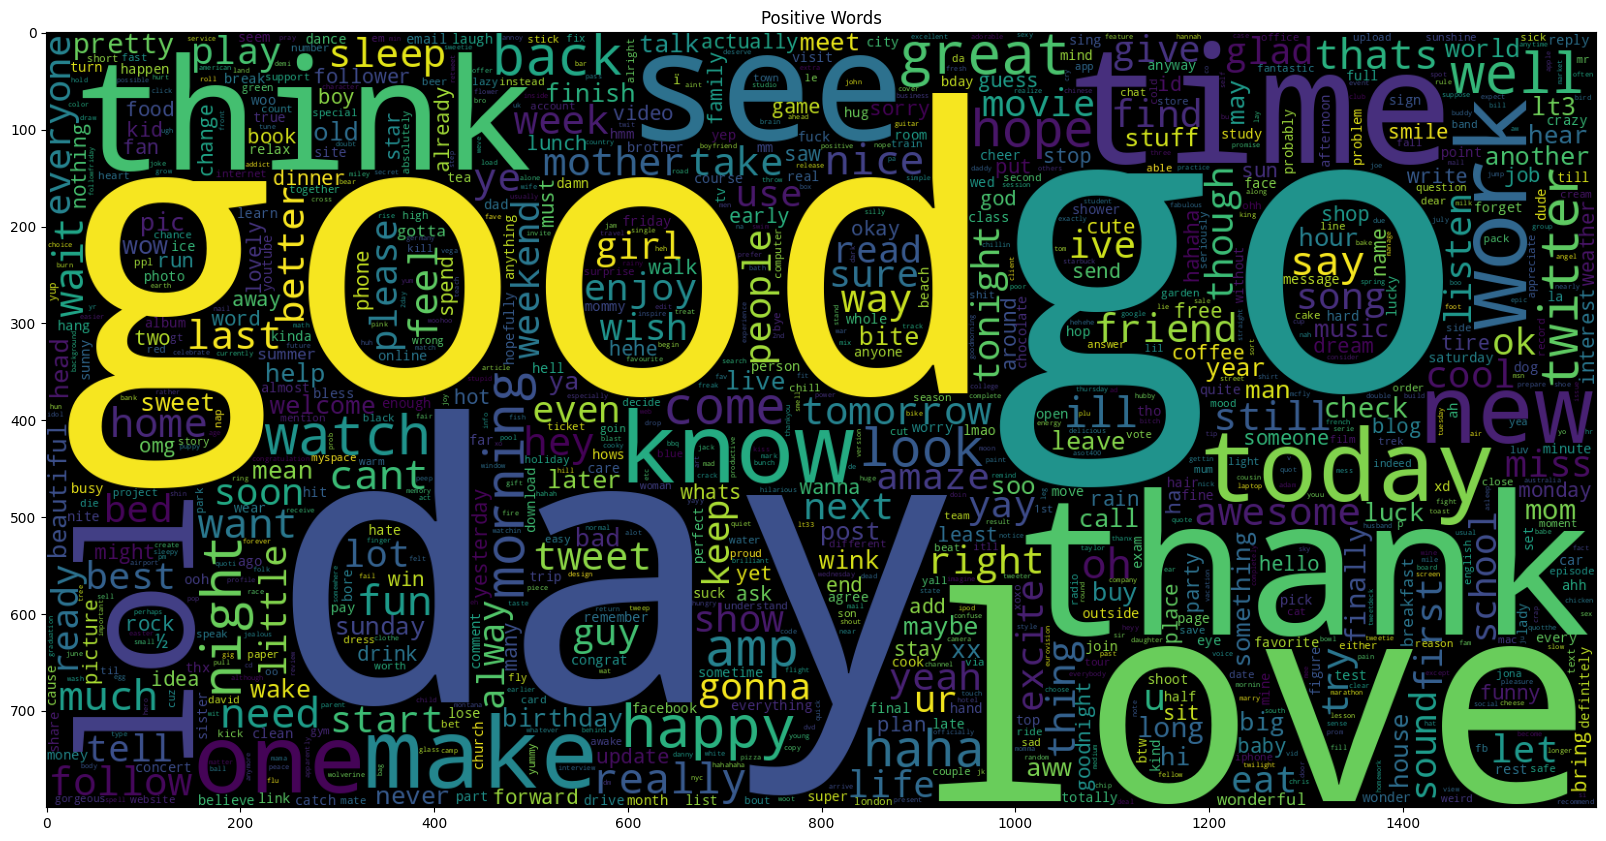

In [ ]:
data_neg = df_new[df_new['target']== 1].text
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)
plt.title ("Positive Words")

Text(0.5, 1.0, 'Negative Words')

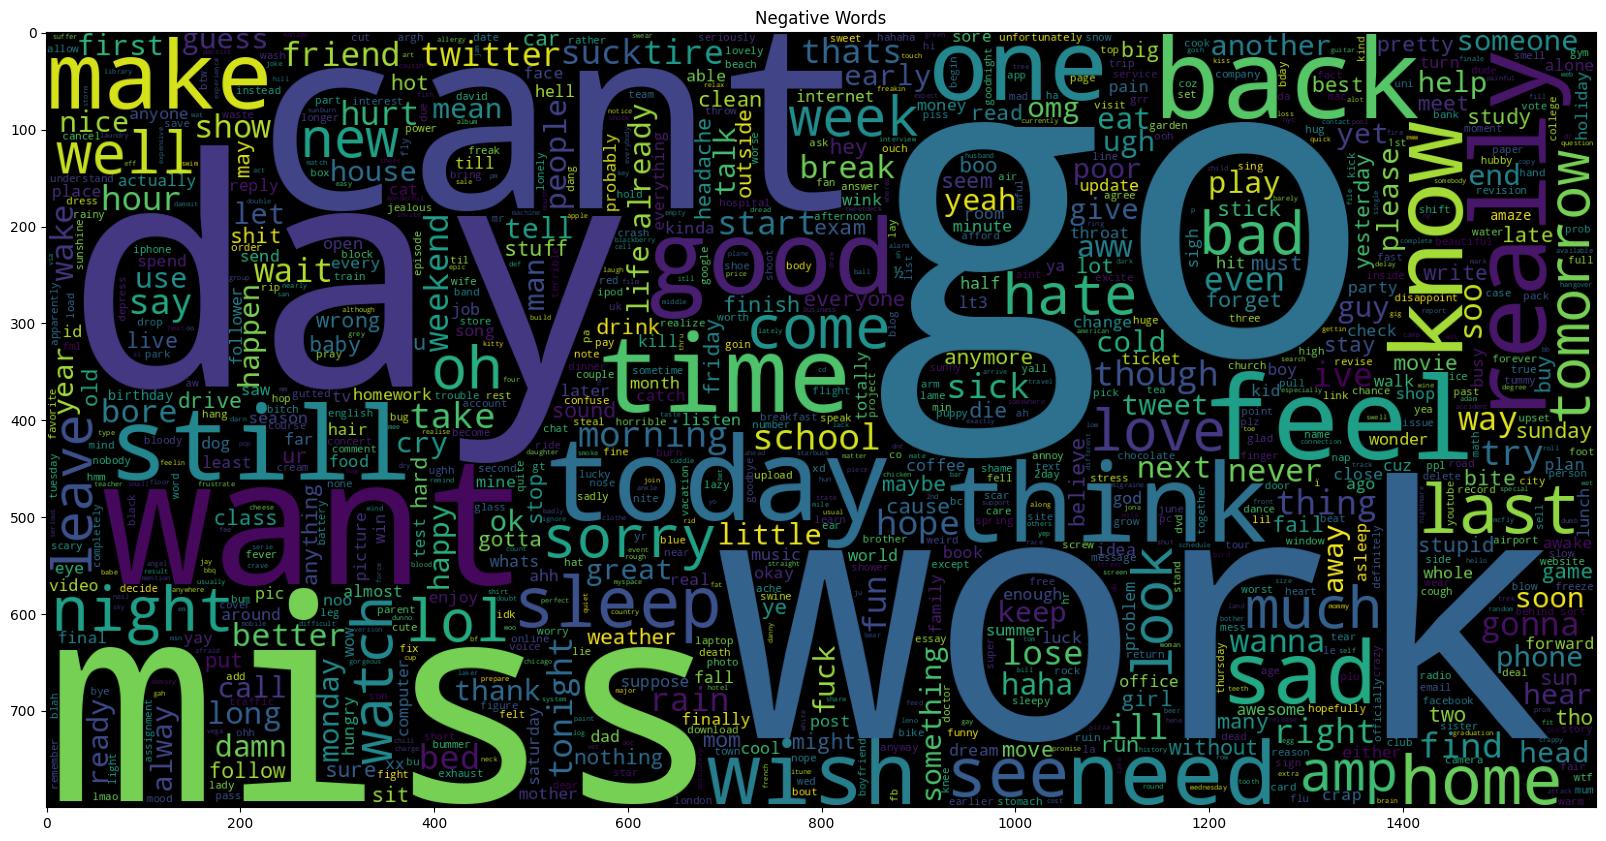

In [ ]:
data_neg = df_new[df_new['target']== 0].text
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)
plt.title ("Negative Words")

In [ ]:
X = df_new['text']
y = df_new['target']

In [ ]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split (X,y, test_size = 0.2, random_state = 1211)
X_train, X_valid, y_train, y_valid = train_test_split (X_temp, y_temp, test_size = 0.2, random_state = 1211)

In [ ]:
vectoriser = CountVectorizer(max_features=100000)
vectoriser.fit(X_train.values)
X_train_count = vectoriser.transform(X_train)
X_valid_count = vectoriser.transform(X_valid)
X_test_count = vectoriser.transform(X_test)

In [ ]:
# Import Necessary Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
clf_nb = MultinomialNB(alpha = 1.0, class_prior = None, fit_prior = True)
clf_nb.fit(X_train_count,y_train)

MultinomialNB()

In [ ]:
clf_nb.score (X_train_count, y_train)

0.81254296875

In [ ]:
clf_nb.score (X_valid_count, y_valid)

0.755390625

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

model_sgd = SGDClassifier(max_iter=1000, n_jobs=-1, loss = 'log_loss')

param_grid_sgd = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1'] # Adding regularization to minimize overfitting
}

clf_sgd = GridSearchCV(model_sgd, param_grid_sgd, cv=3, return_train_score=False)

clf_sgd.fit(X_train_count, y_train)

best_params_sgd = clf_sgd.best_params_
best_score_sgd = clf_sgd.best_score_
clf_sgd_best = clf_sgd.best_estimator_

print("Best Hyperparameters:", best_params_sgd)
print("Best Score:", best_score_sgd)

Best Hyperparameters: {'alpha': 0.0001, 'penalty': 'l2'}
Best Score: 0.7607890588916396


In [ ]:
clf_sgd_best.score(X_train_count, y_train)

0.773515625

In [ ]:
clf_sgd_best.score(X_valid_count, y_valid)


0.759796875

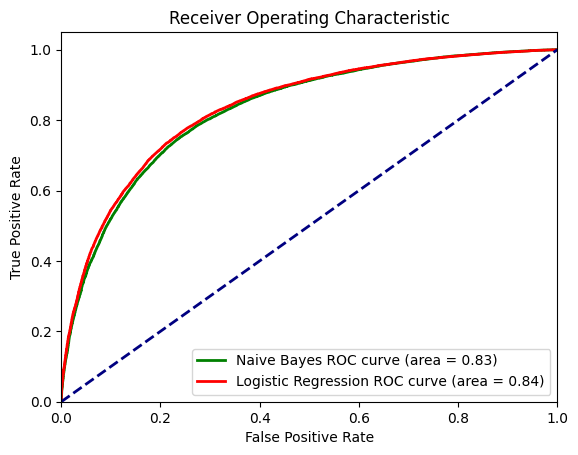

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_nb_probs = clf_nb.predict_proba(X_valid_count)[:,1]
y_lr_probs = clf_sgd_best.predict_proba(X_valid_count)[:,1]

auc_nb = roc_auc_score(y_valid, y_nb_probs)
auc_lr = roc_auc_score(y_valid, y_lr_probs)

lw = 2

fpr_nb, tpr_nb,thresholds_nb = roc_curve(y_valid, y_nb_probs, pos_label=1)
fpr_lr, tpr_lr,thresholds_lr = roc_curve(y_valid, y_lr_probs, pos_label=1)

plt.plot(fpr_nb, tpr_nb, lw = 2, color ='green', label=f'Naive Bayes ROC curve (area = {auc_nb:.2f})' )
plt.plot(fpr_lr, tpr_lr, lw = 2, color ='red', label=f'Logistic Regression ROC curve (area = {auc_lr:.2f})' )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
clf_sgd_best.score(X_test_count, y_test)

0.7616125

In [ ]:
y_pred = clf_sgd_best.predict(X_test_count)

In [ ]:
from sklearn.metrics import classification_report
print (classification_report( y_pred, y_test))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75     37396
           1       0.80      0.74      0.77     42604

    accuracy                           0.76     80000
   macro avg       0.76      0.76      0.76     80000
weighted avg       0.76      0.76      0.76     80000



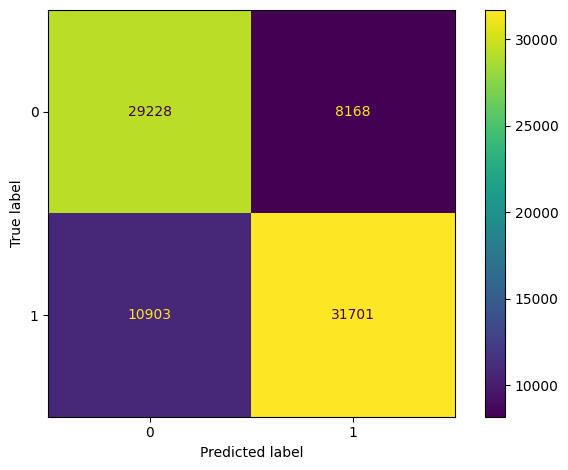

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

mat = confusion_matrix (y_pred, y_test)
dis = ConfusionMatrixDisplay( confusion_matrix = mat)
dis.plot()
plt.tight_layout()
plt.show()


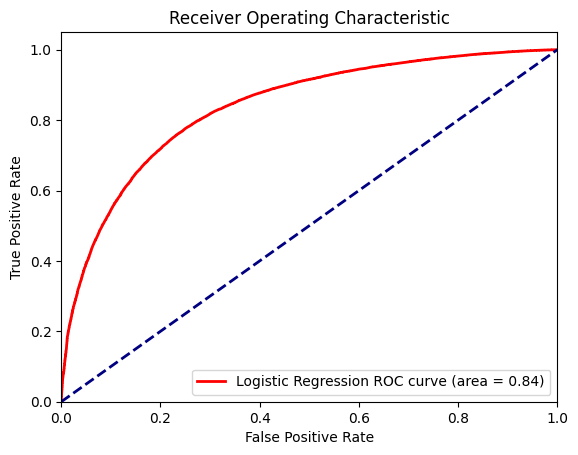

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_lr_probs = clf_sgd_best.predict_proba(X_test_count)[:,1]
auc_lr = roc_auc_score(y_test, y_lr_probs)

lw = 2
fpr_lr, tpr_lr,thresholds_lr = roc_curve(y_test, y_lr_probs, pos_label=1)
plt.plot(fpr_lr, tpr_lr, lw = 2, color ='red', label=f'Logistic Regression ROC curve (area = {auc_lr:.2f})' )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import re
def predict_sentiment(text):
  # Clean the text
  # Define sequencePattern and seqReplacePattern here
  sequencePattern = r"(.)\1\1+"
  seqReplacePattern = r"\1\1"
  text = text.lower()
  text = re.sub(sequencePattern, seqReplacePattern, text) # Replace 3 or more consecutive characters with 2 characters
  text = cleaning_URLs(text)
  text = replacing_emojis(text)
  text = removing_tag(text)
  text = cleaning_punctuations(text)
  text = removing_stopword(text)
  text = removing_single(text)
  text = lemmatization_1(text)
  text = lemmatization_2(text)

  # Vectorize the text
  text_count = vectoriser.transform([text])

  # Predict the sentiment
  prediction = clf_nb.predict(text_count)[0]

  # Return the prediction
  if prediction == 1:
    return "Positive"
  else:
    return "Negative"

# Get the input text from the user
input_text = input("Enter your text: ")

# Predict the sentiment
sentiment = predict_sentiment(input_text)

# Print the sentiment
print(f"The sentiment of the text is: {sentiment}")

Enter your text: hell
The sentiment of the text is: Negative
